<a href="https://colab.research.google.com/github/aadityane93/Neural-Networks/blob/main/stocks_with_lstms.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time Series Prediction with LSTM using PyTorch

## 1. Setup and Imports

First, let's import all the necessary libraries and set up our environment.

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset, DataLoader

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cpu


## 2. Data Loading and Visualization

We'll use the S&P 500 index data from Yahoo Finance. Let's download it and visualize the price trends.

<ipython-input-4-3925027400>:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  sp500 = yf.download('^GSPC', start='2010-01-01', end='2023-12-31')
[*********************100%***********************]  1 of 1 completed


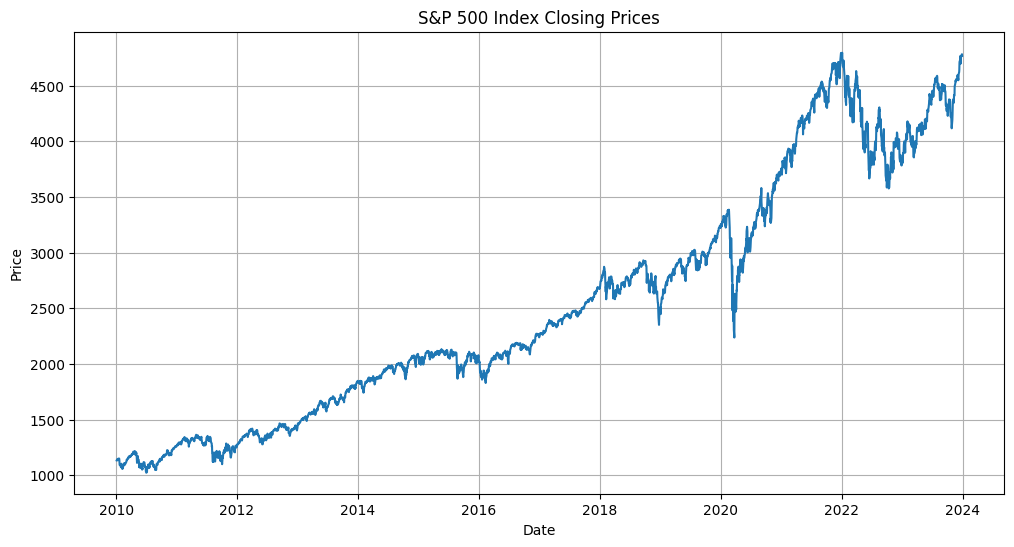

In [ ]:
# Download S&P 500 data
sp500 = yf.download('^GSPC', start='2010-01-01', end='2023-12-31')

# Plot the closing prices
plt.figure(figsize=(12, 6))
plt.plot(sp500['Close'])
plt.title('S&P 500 Index Closing Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid(True)
plt.show()

## 3. Data Preprocessing

We need to:
1. Prepare our data for the LSTM
2. Normalize the data
3. Create sequences for training
4. Split into training and testing sets

In [ ]:
# Prepare data
data = sp500['Close'].values.reshape(-1, 1)

# Normalize the data
scaler = MinMaxScaler()
data_normalized = scaler.fit_transform(data)

# Create sequences for LSTM
def create_sequences(data, seq_length):
    sequences = []
    targets = []
    for i in range(len(data) - seq_length):
        seq = data[i:i + seq_length]
        target = data[i + seq_length]
        sequences.append(seq)
        targets.append(target)
    return np.array(sequences), np.array(targets)

# Parameters
sequence_length = 60    # Number of days to look back
X, y = create_sequences(data_normalized, sequence_length)

# Split into train and test sets (80-20 split)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Convert to PyTorch tensors
X_train = torch.FloatTensor(X_train)
y_train = torch.FloatTensor(y_train)
X_test = torch.FloatTensor(X_test)
y_test = torch.FloatTensor(y_test)

print(f'Training set shape: {X_train.shape}')
print(f'Testing set shape: {X_test.shape}')

Training set shape: torch.Size([2769, 60, 1])
Testing set shape: torch.Size([693, 60, 1])


## 4. Building the LSTM Model

Now, let's create our LSTM model class. We'll use a simple architecture with:
- Input layer
- LSTM layer
- Fully connected layer for prediction

In [ ]:
class LSTMPredictor(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=2, output_size=1):
        super(LSTMPredictor, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # LSTM layer
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)

        # Fully connected layer
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)  # cell state can have the same dimensions as the hidden state

        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))

        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])
        return out

# Initialize the model
model = LSTMPredictor().to(device)

# Define loss function and optimizer
criterion = nn.MSELoss() # use a suitable loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

print(model)

LSTMPredictor(
  (lstm): LSTM(1, 64, num_layers=2, batch_first=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)


## 5. Training the Model

Let's train our LSTM model and visualize the training progress.

Epoch [10/50], Loss: 0.0001
Epoch [20/50], Loss: 0.0001
Epoch [30/50], Loss: 0.0001
Epoch [40/50], Loss: 0.0001
Epoch [50/50], Loss: 0.0001


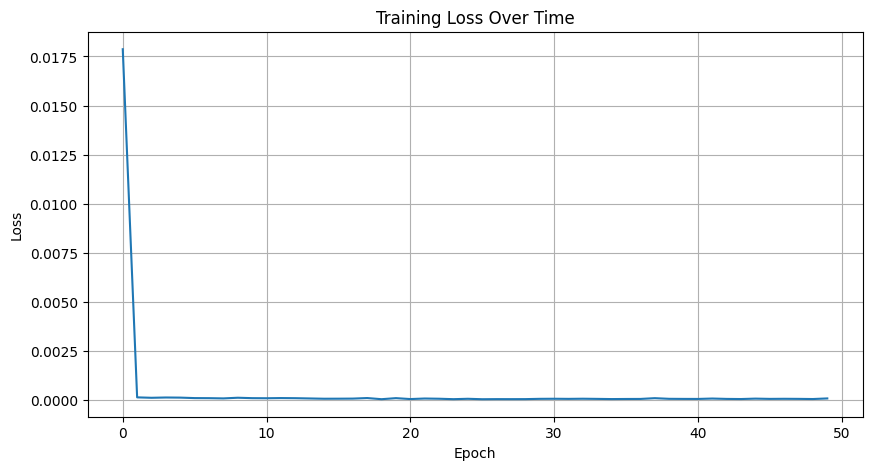

In [ ]:
# Training parameters
num_epochs = 50
batch_size = 32

# Create data loaders
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Training loop
train_losses = []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for batch_X, batch_y in train_loader:
        # Move data to device
        batch_X = batch_X.to(device)
        batch_y = batch_y.to(device)

        # Forward pass
        outputs = model(batch_X)  # COMPLETE
        loss = criterion(outputs, batch_y)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    train_losses.append(avg_loss)

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')

# Plot training loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses)
plt.title('Training Loss Over Time')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

## 6. Evaluation and Visualization

Now let's evaluate our model on the test set and visualize the predictions.

Test MSE: 2509.74
Test RMSE: 50.10
Test MAE: 39.72


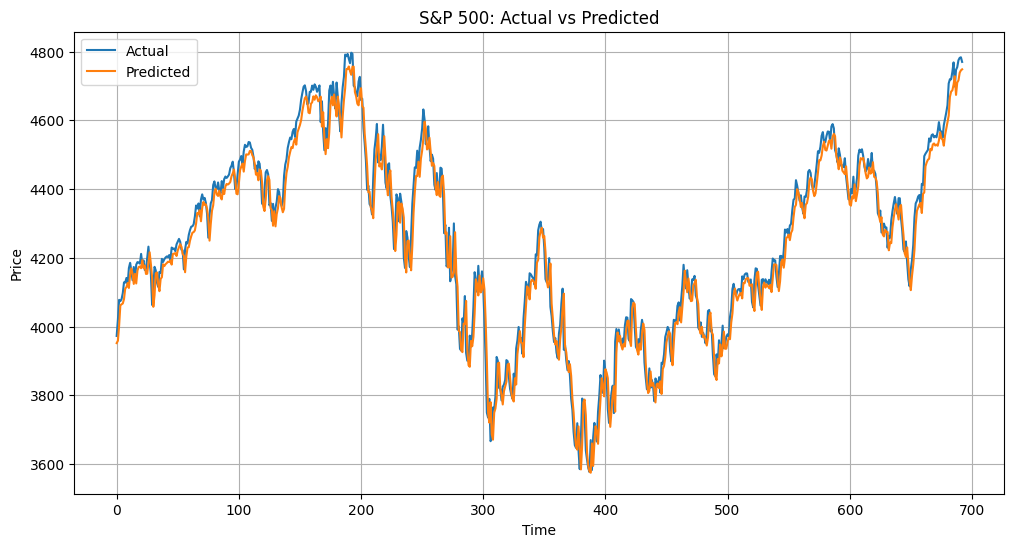

In [ ]:
# Evaluate the model
model.eval()
with torch.no_grad():
    # Make predictions
    X_test = X_test.to(device)
    y_pred = model(X_test) # COMPLETE

    # Convert predictions back to original scale
    y_pred = scaler.inverse_transform(y_pred.cpu().numpy())
    y_test_orig = scaler.inverse_transform(y_test.numpy())

    # Calculate metrics
    mse = np.mean((y_pred - y_test_orig) ** 2)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(y_pred - y_test_orig))

    print(f'Test MSE: {mse:.2f}')
    print(f'Test RMSE: {rmse:.2f}')
    print(f'Test MAE: {mae:.2f}')

    # Plot predictions vs actual
    plt.figure(figsize=(12, 6))
    plt.plot(y_test_orig, label='Actual')
    plt.plot(y_pred, label='Predicted')
    plt.title('S&P 500: Actual vs Predicted')
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.show()